# This notebook is intended to investigate induction heads in attention only models.

#### Part of this code is from Neel Nanda's tutorials on mechanistic interpretability. Specifically, building transformers from scratch tutorial:
https://arena3-chapter1-transformer-interp.streamlit.app/[1.1]_Transformer_from_Scratch

#### Code below is intended to download necessary libraries.

In [1]:
# This notebook uses code from this tutorial: https://colab.research.google.com/drive/1oD26SKGvHaI_UCXWbwwDwI9cSmqQAh3v?authuser=1#scrollTo=jdF6g_7hxgVU
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

if IN_COLAB:
    # Install packages
    %pip install transformer_lens
    %pip install einops
    %pip install jaxtyping
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists(f"/content/{chapter}"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
        !unzip /content/main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
        sys.path.append(f"/content/{repo}-main/{chapter}/exercises")
        os.remove("/content/main.zip")
        os.rename(f"{repo}-main/{chapter}", chapter)
        os.rmdir(f"{repo}-main")
        os.chdir(f"{chapter}/exercises")
else:
    chapter_dir = r"./" if chapter in os.listdir() else os.getcwd().split(chapter)[0]
    sys.path.append(chapter_dir + f"{chapter}/exercises")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found 

In [3]:
import os; os.environ['ACCELERATE_DISABLE_RICH'] = "1"
import sys
import einops
from dataclasses import dataclass
from transformer_lens import HookedTransformer
from transformer_lens.utils import gelu_new, tokenize_and_concatenate
import torch as t
from torch import Tensor
import torch.nn as nn
import numpy as np
import math
from tqdm.notebook import tqdm
from typing import Tuple, List, Optional, Dict, Callable
from jaxtyping import Float, Int
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
from collections import defaultdict
from rich.table import Table
from rich import print as rprint
import datasets
from torch.utils.data import DataLoader
import wandb
from pathlib import Path
import webbrowser

# Make sure exercises are in the path
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part1_transformer_from_scratch").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow
import part1_transformer_from_scratch.solutions as solutions
import part1_transformer_from_scratch.tests as tests

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == '__main__'

reference_gpt2 = HookedTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)

/usr/local/lib/python3.10/dist-packages/accelerate/utils/imports.py:282: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in

Loaded pretrained model gpt2-small into HookedTransformer


### Investigate 2 Layer model from Neel Nanda

In [4]:
attnonly2l = HookedTransformer.from_pretrained("attn-only-1l", fold_ln=False, center_unembed=False, center_writing_weights=False)


config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/205M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformer_lens/utils.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path, map_location="cpu")


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model attn-only-1l into HookedTransformer


In [ ]:
for name, param in attnonly2l.named_parameters():
    # Only print for first layer
    if ".0." in name or "blocks" not in name:
        print(f"{name:18} {tuple(param.shape)}")

embed.W_E          (48262, 512)
pos_embed.W_pos    (1024, 512)
blocks.0.ln1.w     (512,)
blocks.0.ln1.b     (512,)
blocks.0.attn.W_Q  (8, 512, 64)
blocks.0.attn.W_O  (8, 64, 512)
blocks.0.attn.b_Q  (8, 64)
blocks.0.attn.b_O  (512,)
blocks.0.attn.W_K  (8, 512, 64)
blocks.0.attn.W_V  (8, 512, 64)
blocks.0.attn.b_K  (8, 64)
blocks.0.attn.b_V  (8, 64)
ln_final.w         (512,)
ln_final.b         (512,)
unembed.W_U        (512, 48262)
unembed.b_U        (48262,)


In [ ]:
# As a reference - note there's a lot of stuff we don't care about in here, to do with library internals or other architectures
print(attnonly2l.cfg)

HookedTransformerConfig:
{'act_fn': 'solu_ln',
 'attention_dir': 'causal',
 'attn_only': True,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 2048,
 'd_model': 512,
 'd_vocab': 48262,
 'd_vocab_out': 48262,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.035355339059327376,
 'load_in_4bit': False,
 'model_name': 'Attn_Only_1L512W_C4_Code',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 8,
 'n_key_value_heads': None,
 'n_layers': 1,
 'n_params': 1048576,
 'normalization_type': 'LN',
 'num_experts': None,
 'original_architecture': 'neel',
 'output_logits_soft_cap': -1.0,
 'parallel_attn_mlp': False,
 'posit

The settings above will be used to replicate the transformers we are going to do.

### Model configurations

(All the experiments are performed by changing the parameters here, make sure to change d_head to be d_model/n_heads in case you decide to change the number of heads)

In [87]:
@dataclass
class Config:
    d_model: int = 128
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 10
    init_range: float = 0.02
    n_ctx: int = 32
    d_head: int = 64
    n_heads: int = 2
    n_layers: int = 3

cfg = Config()
print(cfg)

Config(d_model=128, debug=True, layer_norm_eps=1e-05, d_vocab=10, init_range=0.02, n_ctx=32, d_head=64, n_heads=2, n_layers=3)


#### Layer Normalisation

In [88]:
class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model))
        self.b = nn.Parameter(t.zeros(cfg.d_model))

    def forward(self, residual: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        residual_mean = residual.mean(dim=-1, keepdim=True)
        residual_std = (residual.var(dim=-1, keepdim=True, unbiased=False) + self.cfg.layer_norm_eps).sqrt()

        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b


### Embedding

In [89]:
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_model"]:
        return self.W_E[tokens]


### Positional Embedding

In [90]:
class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_model"]:
        batch, seq_len = tokens.shape
        return einops.repeat(self.W_pos[:seq_len], "seq d_model -> batch seq d_model", batch=batch)


### Causal Mask

In [91]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"],
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


### Attention

In [92]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        # SOLUTION
        # Calculate query, key and value vectors
        q = einops.einsum(
            normalized_resid_pre, self.W_Q,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
        ) + self.b_Q
        k = einops.einsum(
            normalized_resid_pre, self.W_K,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
        ) + self.b_K
        v = einops.einsum(
            normalized_resid_pre, self.W_V,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
        ) + self.b_V

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k,
            "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K",
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head ** 0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern,
            "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head",
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = einops.einsum(
            z, self.W_O,
            "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model",
        ) + self.b_O

        return attn_out,attn_pattern

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores

### Transformer Block

In [93]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)

    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        # Apply layer normalization
        normed_resid = self.ln1(resid_pre)

        # Get attention output and attention weights
        attn_output, attn_weights = self.attn(normed_resid)

        # Apply the residual connection
        resid_mid = attn_output + resid_pre

        # Return the output (and optionally the attention weights if needed)
        return resid_mid, attn_weights

### Unembedding

In [94]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, normalized_resid_final: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        return einops.einsum(
            normalized_resid_final, self.W_U,
            "batch posn d_model, d_model d_vocab -> batch posn d_vocab",
        ) + self.b_U



### Transfomer

In the code below, positional embedding is commented out because we discovered that even models with one layer can learn an optimal solution in case it's turned on. Therefore, we decide to switch off positional encoding, and we start noticing that results become different.

In [95]:
class Transformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        #self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_vocab"]:
        # SOLUTION
        #residual = self.embed(tokens) + self.pos_embed(tokens)
        residual = self.embed(tokens)
        all_attn_weights = []
        for block in self.blocks:
            residual,attn_weights = block(residual)
            all_attn_weights.append(attn_weights)
        logits = self.unembed(self.ln_final(residual))
        return logits, all_attn_weights

### Define the model

In [96]:
model = Transformer(cfg)

In [36]:
for name, param in model.named_parameters():
    # Only print for first layer
    if ".0." in name or "blocks" not in name:
        print(f"{name:18} {tuple(param.shape)}")

embed.W_E          (10, 128)
pos_embed.W_pos    (32, 128)
blocks.0.ln1.w     (128,)
blocks.0.ln1.b     (128,)
blocks.0.attn.W_Q  (8, 128, 16)
blocks.0.attn.W_K  (8, 128, 16)
blocks.0.attn.W_V  (8, 128, 16)
blocks.0.attn.W_O  (8, 16, 128)
blocks.0.attn.b_Q  (8, 16)
blocks.0.attn.b_K  (8, 16)
blocks.0.attn.b_V  (8, 16)
blocks.0.attn.b_O  (128,)
ln_final.w         (128,)
ln_final.b         (128,)
unembed.W_U        (128, 10)
unembed.b_U        (10,)


### We can change the number of epochs and max number of steps per epoch. When training, I decided to manually stop the code after 5000 steps.

In [97]:
@dataclass
class TransformerTrainingArgs():
	batch_size = 64
	epochs = 200
	max_steps_per_epoch = 1000
	lr = 1e-3
	weight_decay = 1e-2
	wandb_project: Optional[str] = "Transformer_Syn_data2"
	wandb_name: Optional[str] = None


args = TransformerTrainingArgs()

The generated synethetic dataset follows the following structure:



*   A sequence of length n is generated, say 8: 12345678
*   The sequence is repeated m times, say 4: 12345678123456781234567812345678




In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define a class for generating the synthetic dataset
class SyntheticDatasetGenerator:
    def __init__(self, sequence_length=8, repeats=4, seed=3):
        self.sequence_length = sequence_length  # Length of the base sequence
        self.repeats = repeats  # Number of times the sequence is repeated
        if seed is not None:
            np.random.seed(seed)  # Set the random seed for reproducibility

    def generate_data(self, num_sequences):
        """
        Generates a synthetic dataset with random sequences of length sequence_length, repeated repeats times.

        Parameters:
        num_sequences (int): The number of sequences to generate.

        Returns:
        torch.Tensor: A tensor containing the generated dataset, each row is a sequence.
        """
        # Generate random base sequences of length sequence_length
        base_sequences = np.random.randint(0, 10, size=(num_sequences, self.sequence_length))

        # Repeat each sequence 'repeats' times to create a longer sequence
        full_sequences = np.tile(base_sequences, (1, self.repeats))

        # Convert to PyTorch tensor
        return torch.tensor(full_sequences, dtype=torch.long)

# Custom Dataset class compatible with DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.num_rows = data.size(0)

    def __len__(self):
        return self.num_rows

    def __getitem__(self, idx):
        return {'tokens': self.data[idx]}

# Usage of the class to generate training and testing datasets
sequence_length = 8  # Base sequence length
repeats = 4          # Number of times to repeat the sequence
M = 33000            # Total number of sequences
N = sequence_length  # Length of base pattern
T = repeats          # Number of repeats

# Initialize the dataset generator with a seed
dataset_generator = SyntheticDatasetGenerator(sequence_length=N, repeats=T)

# Generate training and testing datasets
train_data = dataset_generator.generate_data(M - 1000)  # Training data (M - 1000 sequences)
test_data = dataset_generator.generate_data(1000)       # Test data (1000 sequences)

# Create DataLoaders for training and testing datasets
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)


NameError: name 'args' is not defined

In [99]:
def get_log_probs(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"]
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)

    return log_probs_for_tokens

In [100]:
class TransformerTrainer:
    def __init__(self, args: TransformerTrainingArgs, model: Transformer):
        super().__init__()
        self.model = model
        self.args = args
        self.optimizer = t.optim.AdamW(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        self.step = 0


    def training_step(self, batch: Dict[str, Int[Tensor, "batch seq"]]) -> Float[Tensor, ""]:
        '''
        Calculates the loss on the tokens in the batch, performs a gradient update step, and logs the loss.

        Remember that `batch` is a dictionary with the single key 'tokens'.
        '''

        tokens = batch["tokens"].to(device)
        logits, all_attn_weights = self.model(tokens)
        loss = -get_log_probs(logits, tokens).mean()

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.step += 1
        wandb.log({"train_loss": loss}, step=self.step)
        #wandb.log({"icl_score": icl_score}, step=self.step)
        return loss


    def validation_step(self, batch: Dict[str, Int[Tensor, "batch seq"]]):
        '''
        Calculates & returns the accuracy on the tokens in the batch (i.e. how often the model's prediction
        is correct). Logging should happen in the `train` function (after we've computed the accuracy for
        the whole validation set).
        '''

        tokens = batch["tokens"].to(device)
        logits, _ = self.model(tokens)  # We only need logits here, so we can ignore attention weights
        predicted_tokens = logits[:, :-1].argmax(dim=-1)
        correct_predictions = (predicted_tokens == tokens[:, 1:]).flatten()
        return correct_predictions


    def train(self):
        '''
        Trains the model, for `self.args.epochs` epochs. Also handles wandb initialisation, and early stopping
        for each epoch at `self.args.max_steps_per_epoch` steps.
        '''

        wandb.init(project=self.args.wandb_project, name=self.args.wandb_name, config=self.args)
        accuracy = np.nan

        progress_bar = tqdm(total = self.args.max_steps_per_epoch * self.args.epochs)

        for epoch in range(self.args.epochs):
            for i, batch in enumerate(self.train_loader()):
                loss = self.training_step(batch)
                progress_bar.update()
                progress_bar.set_description(f"Epoch {epoch+1}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

                if i >= self.args.max_steps_per_epoch:
                    break

            correct_predictions = t.concat([self.validation_step(batch) for batch in self.test_loader()])
            accuracy = correct_predictions.float().mean().item()


            wandb.log({"accuracy": accuracy}, step=self.step)

        wandb.finish()


    def train_loader(self) -> DataLoader:
        '''Returns train loader (as in code above).'''
        #return DataLoader(dataset_dict["train"], batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        return DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def test_loader(self) -> DataLoader:
        '''Returns test loader (as in code above).'''
        #return DataLoader(dataset_dict["test"], batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)
        return DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [101]:
model = Transformer(cfg).to(device)
args = TransformerTrainingArgs()
trainer = TransformerTrainer(args, model)
trainer.train()


accuracy,▁▂▄▅▅▅▆▆▇▇▇▇▇████
train_loss,█▄▄▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁
accuracy,0.61723
train_loss,1.02348


  0%|          | 0/200000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 1 Layer experiments
For the experiment here: we have 1 layer attention-only transformer with 8 heads.

In [40]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 2).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Predicted tokens: [1, 2, 1, 1, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2]
Accuracy:        6.67%


Here, we visualise the logits before and after seeing the sequence.

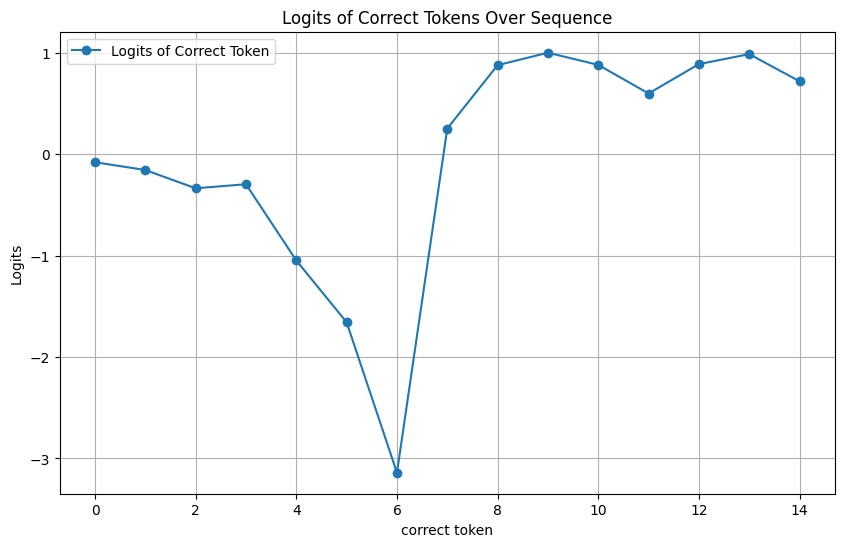

In [51]:
import matplotlib.pyplot as plt
# Shift true tokens by one position to align with predictions
true_tokens = tokens[:, 1:]

# Extract the logits of the correct token at each position
correct_logits = logits[:, :-1].gather(2, true_tokens.unsqueeze(-1)).squeeze(-1)

# Convert tensors to CPU for plotting
correct_logits = correct_logits.squeeze().cpu().detach().numpy()

# Create a line plot of logits for the correct token at each position
plt.figure(figsize=(10, 6))
plt.plot(correct_logits, label='Logits of Correct Token', marker='o')
plt.title('Logits of Correct Tokens Over Sequence')
plt.xlabel('correct token')
plt.ylabel('Logits')
plt.legend()
plt.grid(True)
plt.show()

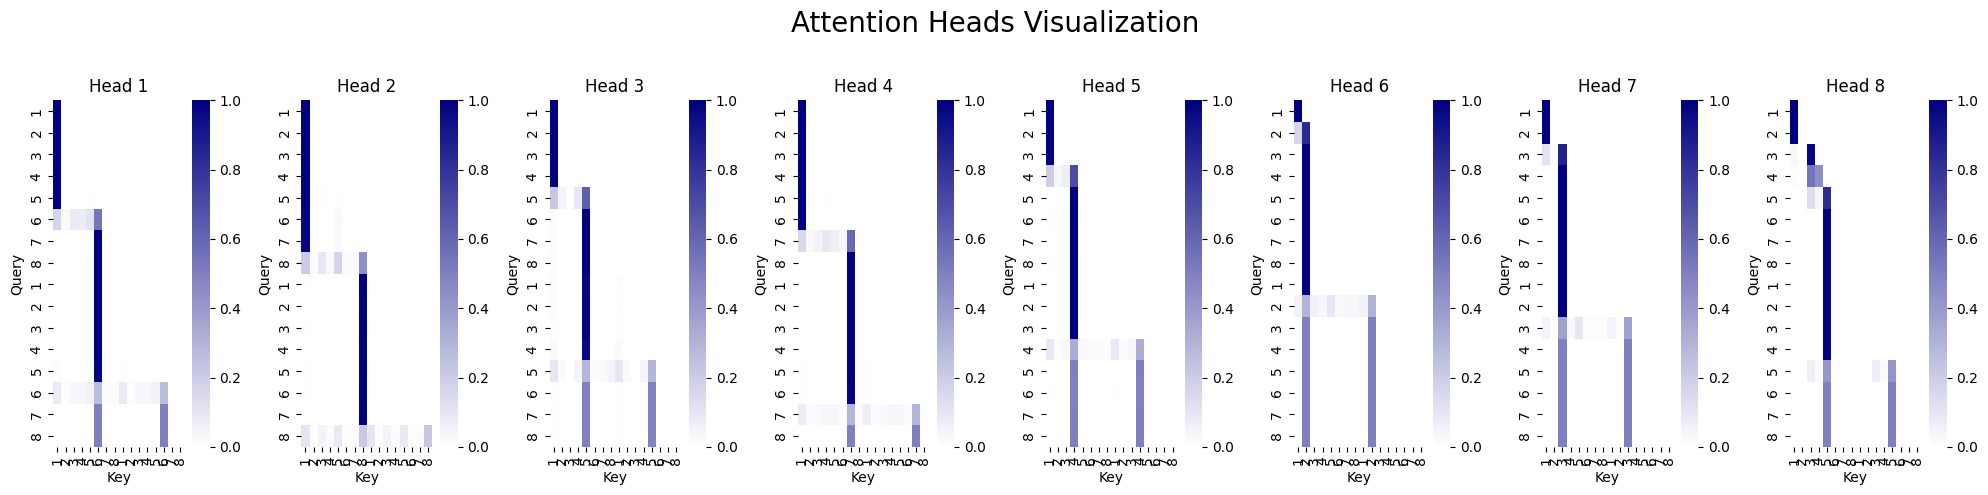

In [53]:

import seaborn as sns
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_attention_one_layer(attn_weights, tokens, title="Attention Heads Visualization"):
    """
    Visualizes the attention weights for all heads in a single layer in a single figure.

    :param attn_weights: The attention weights tensor of shape (batch_size, n_heads, seq_len, seq_len) for a single layer
    :param tokens: The tokens to be annotated on the x and y axis
    :param title: The title for the plot
    """
    n_heads = attn_weights.size(1)   # Number of heads in the layer
    seq_len = attn_weights.size(-1)  # Sequence length

    # Create a custom color map where 0 is white and the rest is a gradient from white to blue
    colors = [(1, 1, 1), (0.0, 0.0, 0.5)]  # White to blue gradient
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    fig, axes = plt.subplots(1, n_heads, figsize=(20, 5))  # Adjust figure size based on the number of heads
    fig.suptitle(title, fontsize=20)

    for head in range(n_heads):
        ax = axes[head]  # Position based on head index
        attn = attn_weights[0, head].detach().cpu().numpy()  # attn_weights[batch, head, seq_len, seq_len]

        sns.heatmap(attn, cmap=cmap, annot=False, fmt=".2f", xticklabels=tokens, yticklabels=tokens, ax=ax, cbar=True)
        ax.set_title(f"Head {head + 1}")
        ax.set_xlabel("Key")
        ax.set_ylabel("Query")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()

# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # all_attn_weights is still a list, even for a single layer

    # Extract the attention weights for the first (and only) layer
    attn_weights = all_attn_weights[0]  # First and only layer in the list

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for the single layer
    visualize_attention_one_layer(attn_weights, tokens_str)


In [54]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 4).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Predicted tokens: [1, 2, 1, 1, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2]
Accuracy:        9.68%


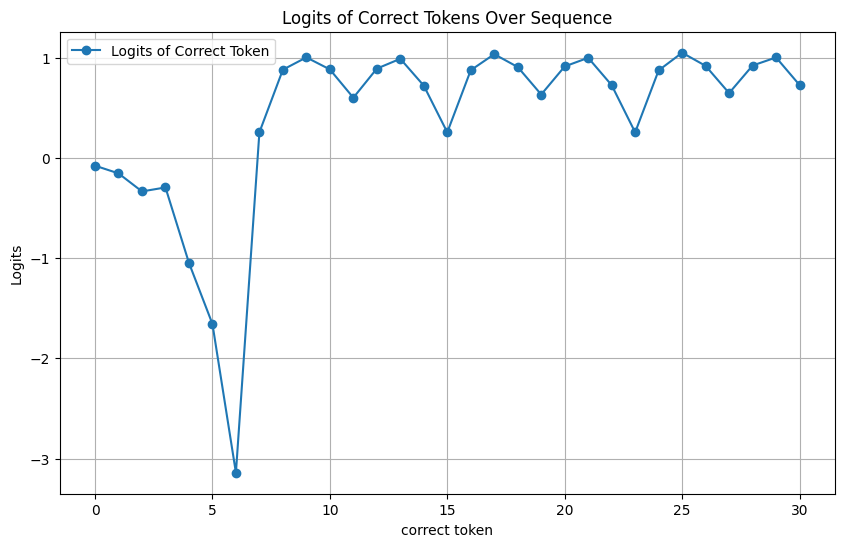

In [55]:
import matplotlib.pyplot as plt
# Shift true tokens by one position to align with predictions
true_tokens = tokens[:, 1:]

# Extract the logits of the correct token at each position
correct_logits = logits[:, :-1].gather(2, true_tokens.unsqueeze(-1)).squeeze(-1)

# Convert tensors to CPU for plotting
correct_logits = correct_logits.squeeze().cpu().detach().numpy()

# Create a line plot of logits for the correct token at each position
plt.figure(figsize=(10, 6))
plt.plot(correct_logits, label='Logits of Correct Token', marker='o')
plt.title('Logits of Correct Tokens Over Sequence')
plt.xlabel('correct token')
plt.ylabel('Logits')
plt.legend()
plt.grid(True)
plt.show()

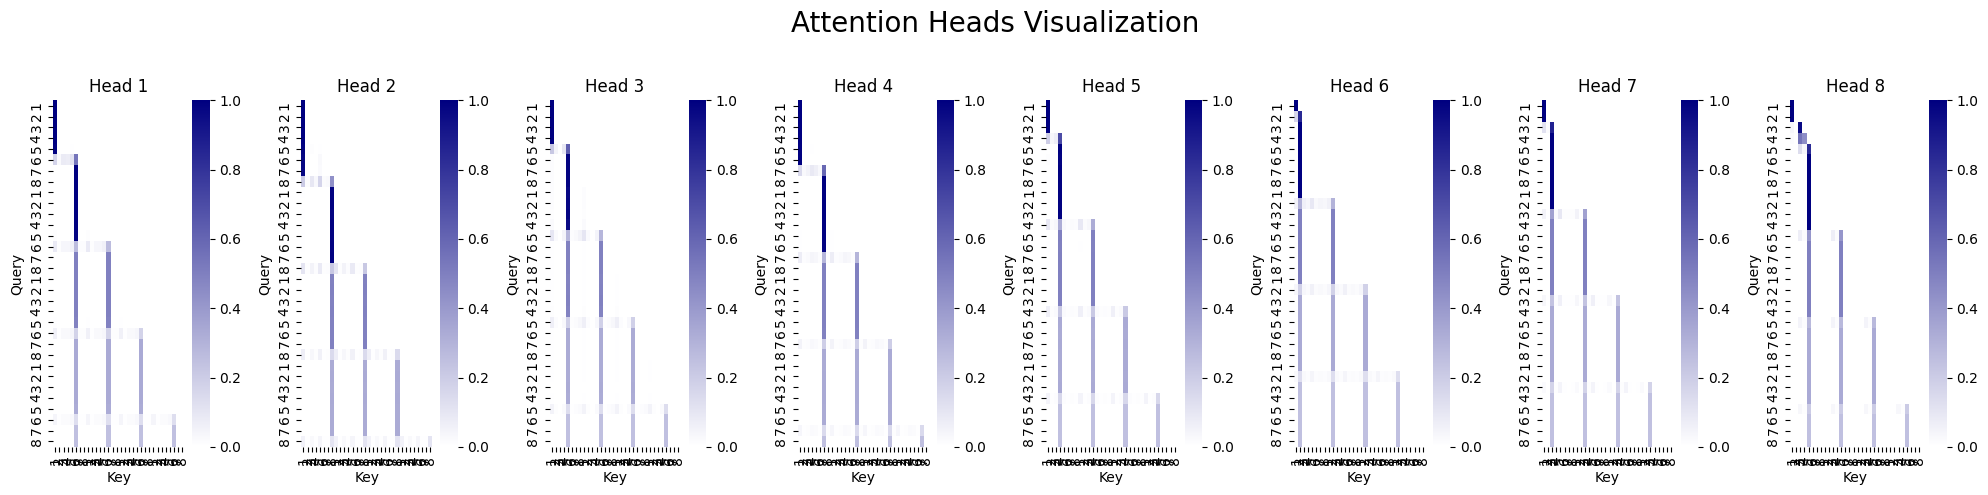

In [56]:

import seaborn as sns
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_attention_one_layer(attn_weights, tokens, title="Attention Heads Visualization"):
    """
    Visualizes the attention weights for all heads in a single layer in a single figure.

    :param attn_weights: The attention weights tensor of shape (batch_size, n_heads, seq_len, seq_len) for a single layer
    :param tokens: The tokens to be annotated on the x and y axis
    :param title: The title for the plot
    """
    n_heads = attn_weights.size(1)   # Number of heads in the layer
    seq_len = attn_weights.size(-1)  # Sequence length

    # Create a custom color map where 0 is white and the rest is a gradient from white to blue
    colors = [(1, 1, 1), (0.0, 0.0, 0.5)]  # White to blue gradient
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    fig, axes = plt.subplots(1, n_heads, figsize=(20, 5))  # Adjust figure size based on the number of heads
    fig.suptitle(title, fontsize=20)

    for head in range(n_heads):
        ax = axes[head]  # Position based on head index
        attn = attn_weights[0, head].detach().cpu().numpy()  # attn_weights[batch, head, seq_len, seq_len]

        sns.heatmap(attn, cmap=cmap, annot=False, fmt=".2f", xticklabels=tokens, yticklabels=tokens, ax=ax, cbar=True)
        ax.set_title(f"Head {head + 1}")
        ax.set_xlabel("Key")
        ax.set_ylabel("Query")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()

# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # all_attn_weights is still a list, even for a single layer

    # Extract the attention weights for the first (and only) layer
    attn_weights = all_attn_weights[0]  # First and only layer in the list

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for the single layer
    visualize_attention_one_layer(attn_weights, tokens_str)


### Observation: We can see that with a 1 layer transfomer, the model fails to learn the task.

# 2Layers 4heads

In [72]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 2).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Predicted tokens: [5, 3, 1, 1, 1, 1, 1, 1, 1, 3, 4, 5, 6, 7, 8]
Accuracy:        53.33%


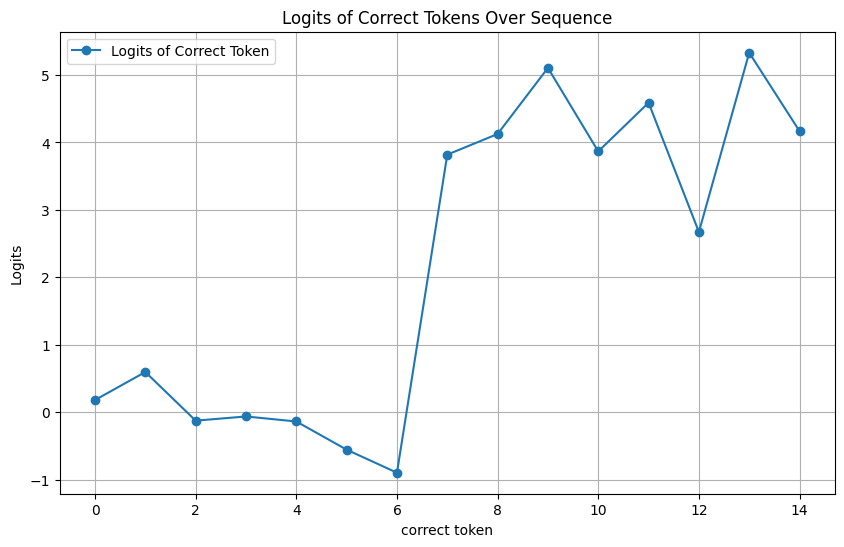

In [74]:
import matplotlib.pyplot as plt
# Shift true tokens by one position to align with predictions
true_tokens = tokens[:, 1:]

# Extract the logits of the correct token at each position
correct_logits = logits[:, :-1].gather(2, true_tokens.unsqueeze(-1)).squeeze(-1)

# Convert tensors to CPU for plotting
correct_logits = correct_logits.squeeze().cpu().detach().numpy()

# Create a line plot of logits for the correct token at each position
plt.figure(figsize=(10, 6))
plt.plot(correct_logits, label='Logits of Correct Token', marker='o')
plt.title('Logits of Correct Tokens Over Sequence')
plt.xlabel('correct token')
plt.ylabel('Logits')
plt.legend()
plt.grid(True)
plt.show()

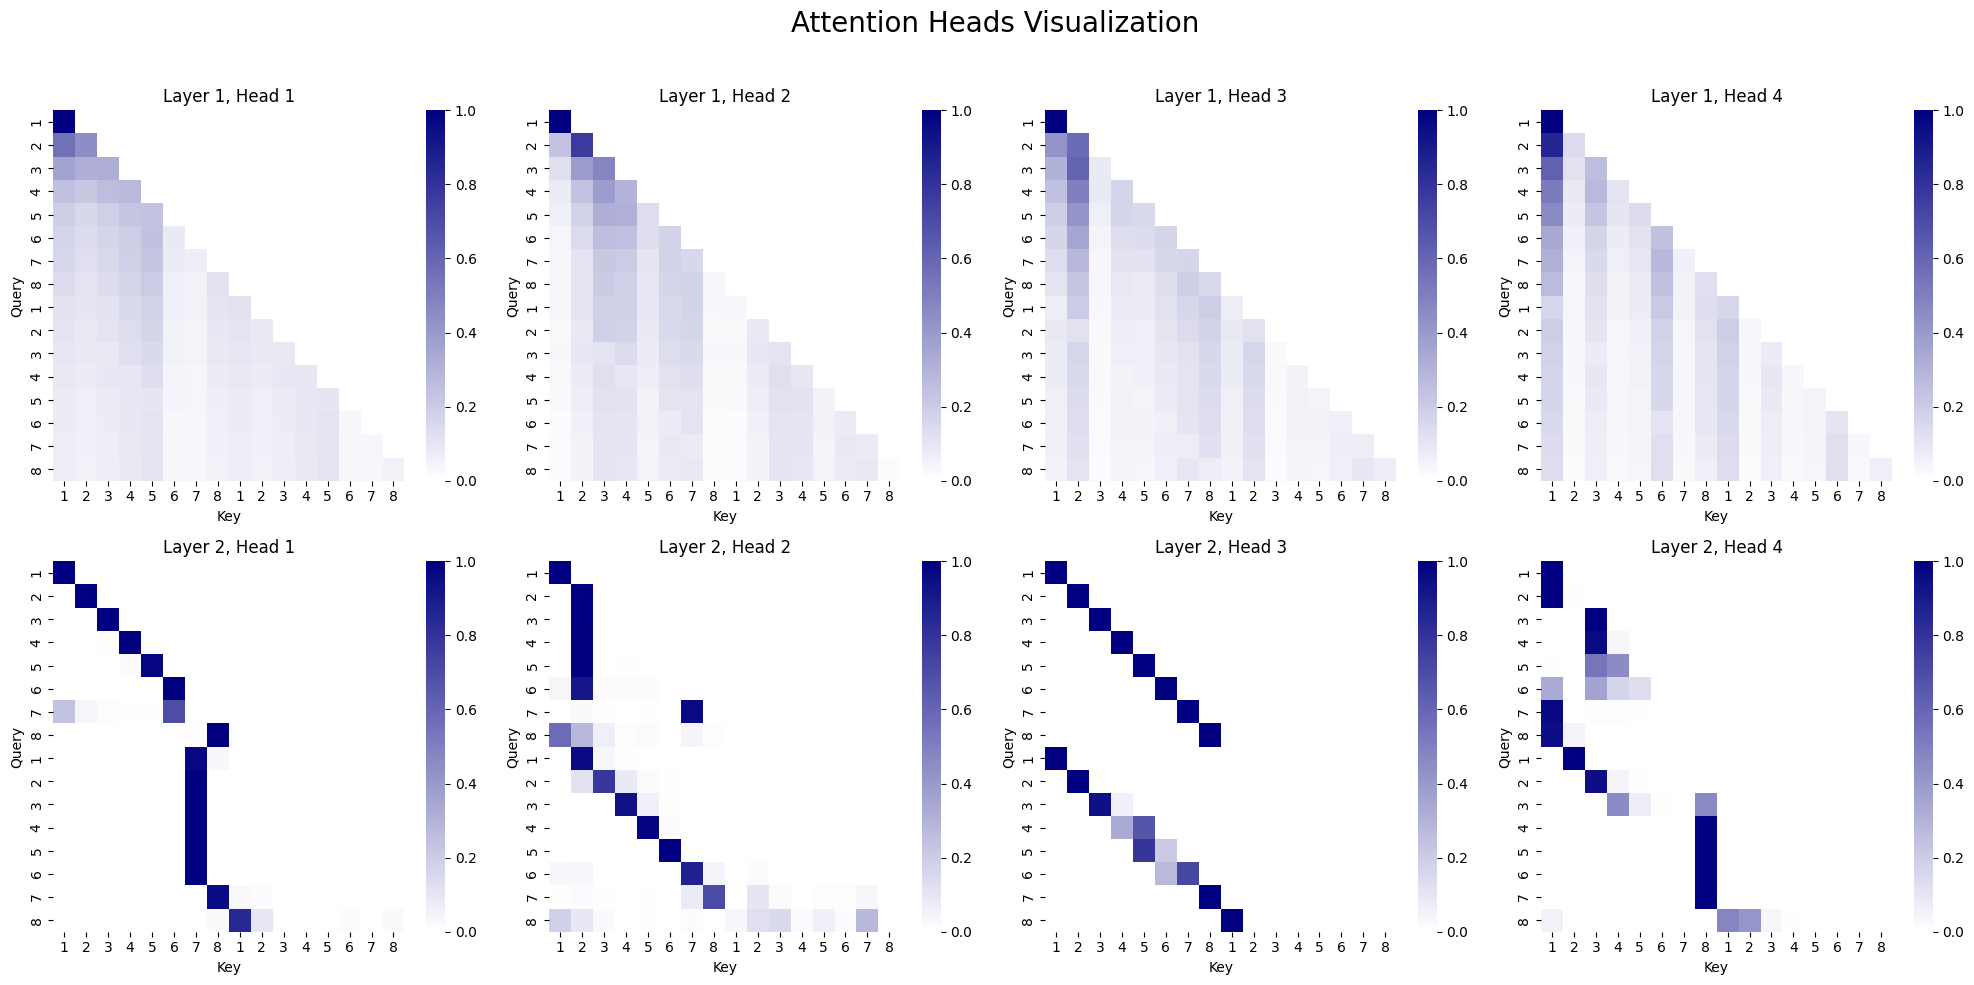

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_attention_all_layers(attn_weights_list, tokens, title="Attention Heads Visualization"):
    """
    Visualizes the attention weights for all heads across all layers in a single figure.

    :param attn_weights_list: The attention weights list where each element is a tensor of shape (batch_size, n_heads, seq_len, seq_len)
    :param tokens: The tokens to be annotated on the x and y axis
    :param title: The title for the plot
    """
    n_layers = len(attn_weights_list)  # Number of layers
    n_heads = attn_weights_list[0].size(1)   # Number of heads per layer (assuming uniform heads per layer)
    seq_len = attn_weights_list[0].size(-1)  # Sequence length (assuming uniform seq_len across layers)

    # Create a custom color map where 0 is white and the rest is a gradient from white to blue
    colors = [(1, 1, 1), (0.0, 0.0, 0.5)]  # White to blue gradient
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    fig, axes = plt.subplots(n_layers, n_heads, figsize=(20, n_layers * 5))  # Adjust figure size based on layers and heads
    fig.suptitle(title, fontsize=20)

    for layer in range(n_layers):
        for head in range(n_heads):
            ax = axes[layer, head]  # Position based on layer and head index
            attn = attn_weights_list[layer][0, head].detach().cpu().numpy()  # attn_weights[layer][batch, head, seq_len, seq_len]

            sns.heatmap(attn, cmap=cmap, annot=False, fmt=".2f", xticklabels=tokens, yticklabels=tokens, ax=ax, cbar=True)
            ax.set_title(f"Layer {layer + 1}, Head {head + 1}")
            ax.set_xlabel("Key")
            ax.set_ylabel("Query")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()

# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # Assume all_attn_weights is a list of attention weight tensors (one per layer)

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for all heads across all layers
    visualize_attention_all_layers(all_attn_weights, tokens_str)


In [75]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 4).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Predicted tokens: [5, 3, 1, 1, 1, 1, 1, 1, 1, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Accuracy:        77.42%


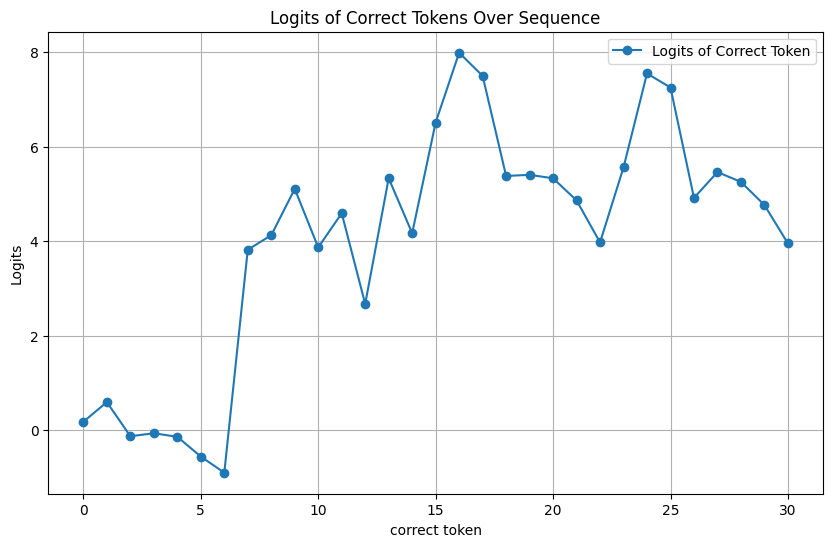

In [76]:
import matplotlib.pyplot as plt
# Shift true tokens by one position to align with predictions
true_tokens = tokens[:, 1:]

# Extract the logits of the correct token at each position
correct_logits = logits[:, :-1].gather(2, true_tokens.unsqueeze(-1)).squeeze(-1)

# Convert tensors to CPU for plotting
correct_logits = correct_logits.squeeze().cpu().detach().numpy()

# Create a line plot of logits for the correct token at each position
plt.figure(figsize=(10, 6))
plt.plot(correct_logits, label='Logits of Correct Token', marker='o')
plt.title('Logits of Correct Tokens Over Sequence')
plt.xlabel('correct token')
plt.ylabel('Logits')
plt.legend()
plt.grid(True)
plt.show()

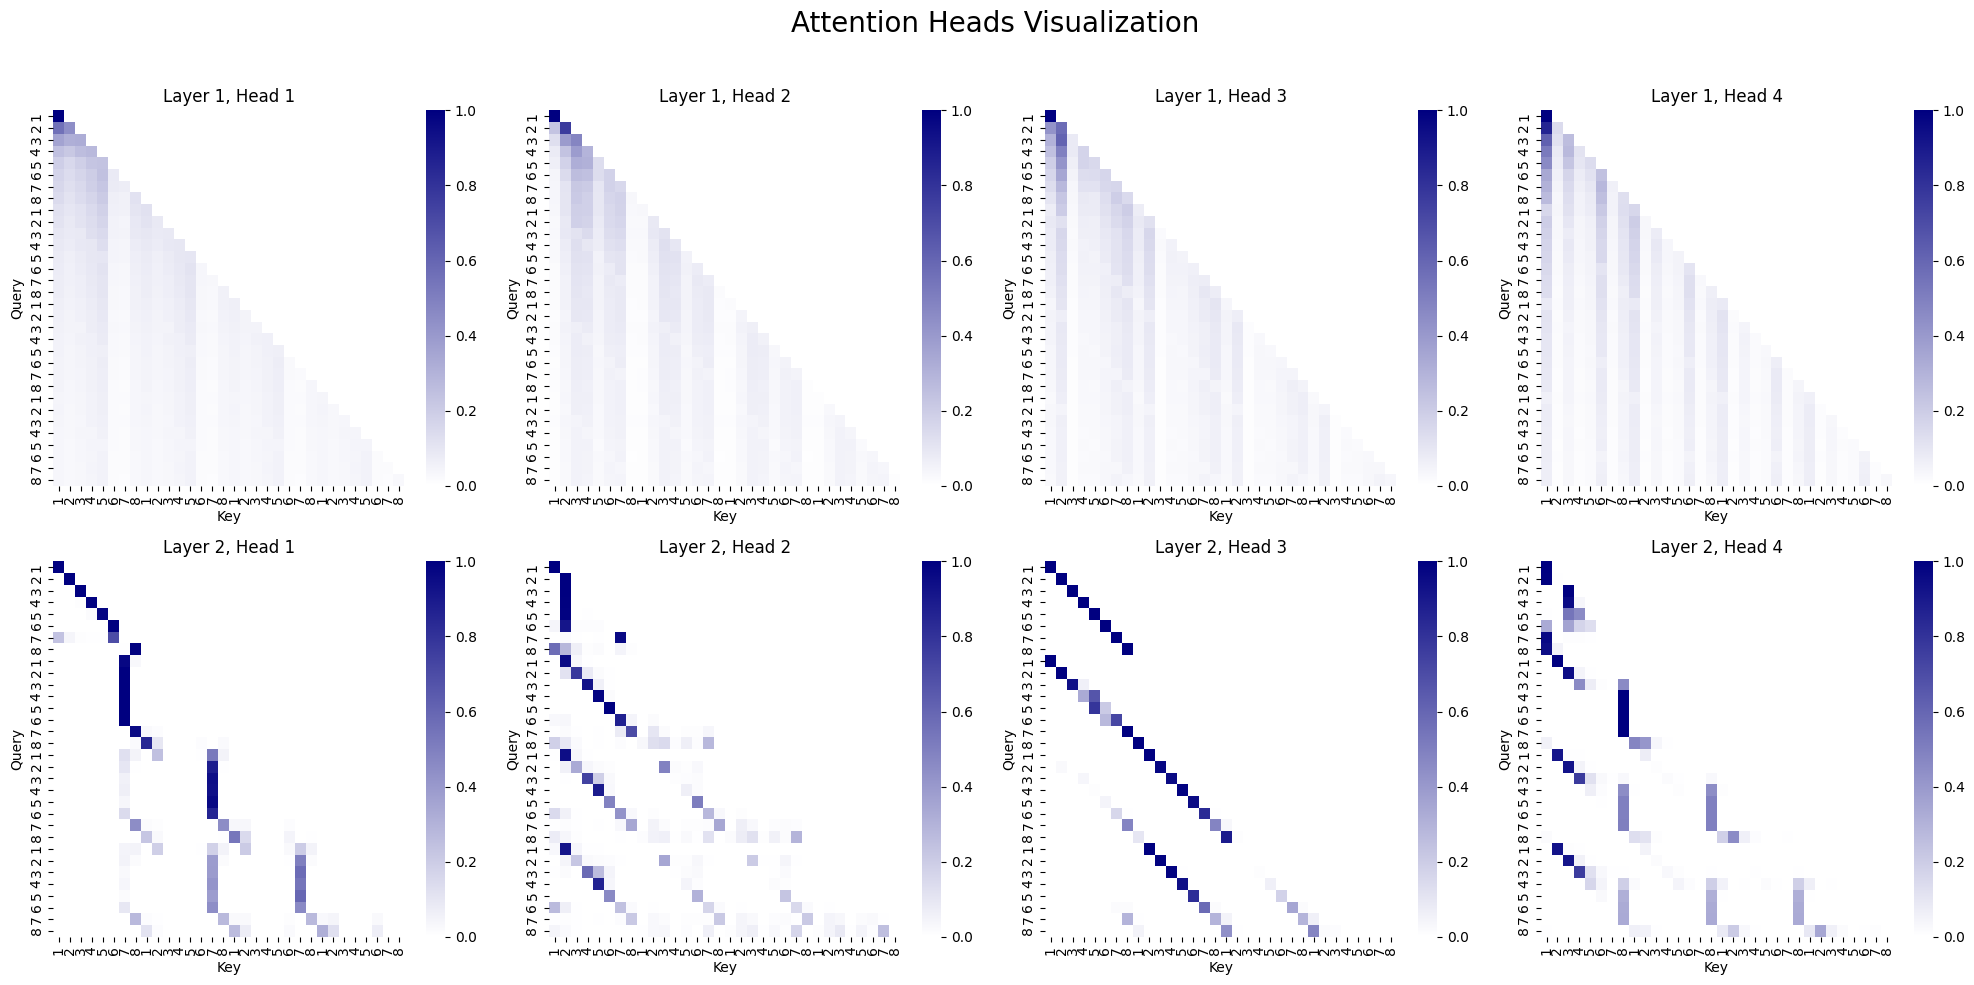

In [77]:


# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # Assume all_attn_weights is a list of attention weight tensors (one per layer)

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for all heads across all layers
    visualize_attention_all_layers(all_attn_weights, tokens_str)


In [84]:
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 4)  # Move pattern to the device
any(torch.equal(row, pattern2) for row in train_data)

False

In [85]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8,9,8,7,6,5,4,3,2]*2).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2]
Predicted tokens: [5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 5, 6, 7, 8, 7, 8, 7, 6, 5, 4, 3, 2]
Accuracy:        41.94%


### Observation: the 2-layers transformer was able to learn the problem of repeating sequence. However, it struggled when the pattern became ABAB, but started learning it at a later step.

# 3Layers2heads

In [102]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 2).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Predicted tokens: [7, 1, 1, 4, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8]
Accuracy:        53.33%


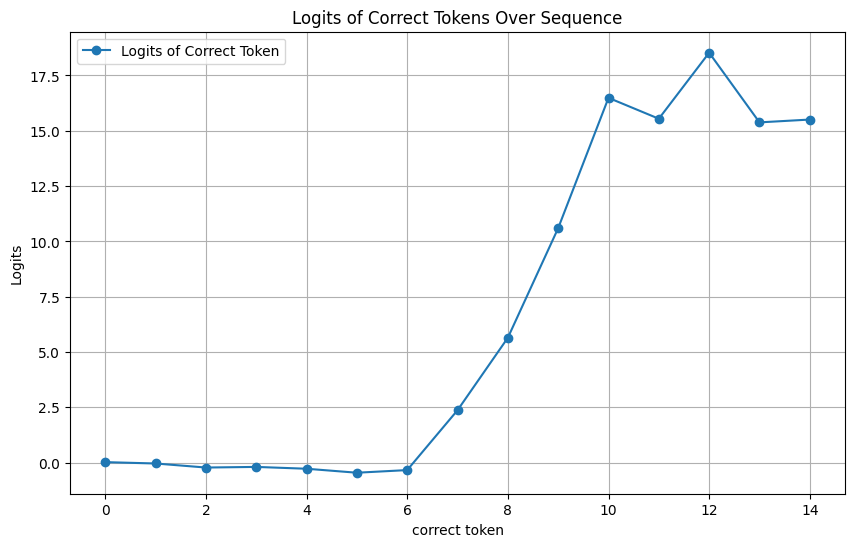

In [103]:
import matplotlib.pyplot as plt
# Shift true tokens by one position to align with predictions
true_tokens = tokens[:, 1:]

# Extract the logits of the correct token at each position
correct_logits = logits[:, :-1].gather(2, true_tokens.unsqueeze(-1)).squeeze(-1)

# Convert tensors to CPU for plotting
correct_logits = correct_logits.squeeze().cpu().detach().numpy()

# Create a line plot of logits for the correct token at each position
plt.figure(figsize=(10, 6))
plt.plot(correct_logits, label='Logits of Correct Token', marker='o')
plt.title('Logits of Correct Tokens Over Sequence')
plt.xlabel('correct token')
plt.ylabel('Logits')
plt.legend()
plt.grid(True)
plt.show()

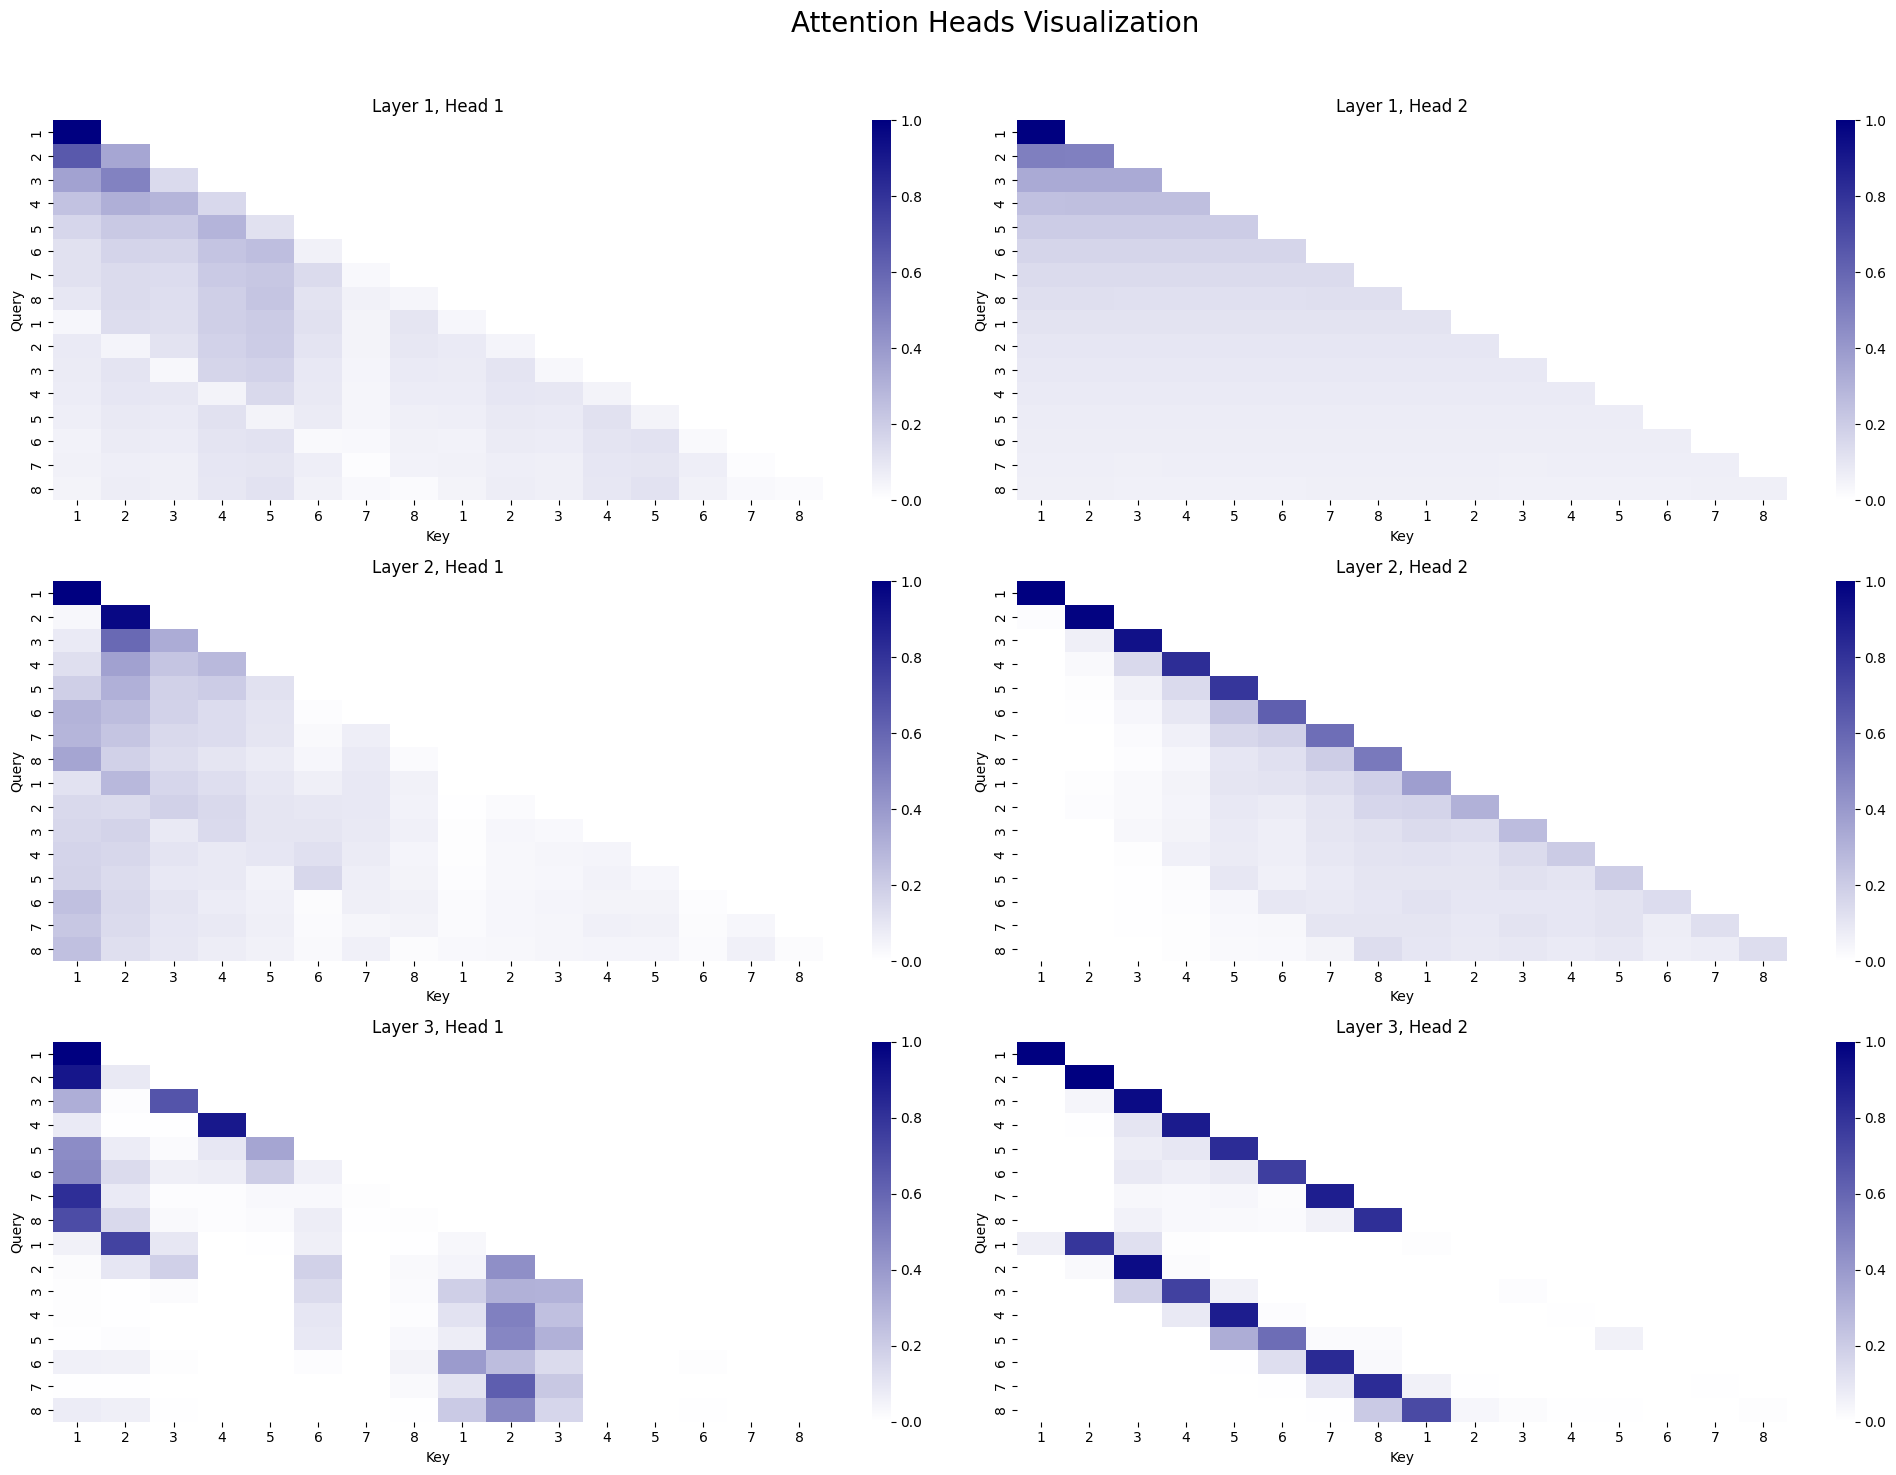

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_attention_all_layers(attn_weights_list, tokens, title="Attention Heads Visualization"):
    """
    Visualizes the attention weights for all heads across all layers in a single figure.

    :param attn_weights_list: The attention weights list where each element is a tensor of shape (batch_size, n_heads, seq_len, seq_len)
    :param tokens: The tokens to be annotated on the x and y axis
    :param title: The title for the plot
    """
    n_layers = len(attn_weights_list)  # Number of layers
    n_heads = attn_weights_list[0].size(1)   # Number of heads per layer (assuming uniform heads per layer)
    seq_len = attn_weights_list[0].size(-1)  # Sequence length (assuming uniform seq_len across layers)

    # Create a custom color map where 0 is white and the rest is a gradient from white to blue
    colors = [(1, 1, 1), (0.0, 0.0, 0.5)]  # White to blue gradient
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    fig, axes = plt.subplots(n_layers, n_heads, figsize=(20, n_layers * 5))  # Adjust figure size based on layers and heads
    fig.suptitle(title, fontsize=20)

    for layer in range(n_layers):
        for head in range(n_heads):
            ax = axes[layer, head]  # Position based on layer and head index
            attn = attn_weights_list[layer][0, head].detach().cpu().numpy()  # attn_weights[layer][batch, head, seq_len, seq_len]

            sns.heatmap(attn, cmap=cmap, annot=False, fmt=".2f", xticklabels=tokens, yticklabels=tokens, ax=ax, cbar=True)
            ax.set_title(f"Layer {layer + 1}, Head {head + 1}")
            ax.set_xlabel("Key")
            ax.set_ylabel("Query")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()

# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # Assume all_attn_weights is a list of attention weight tensors (one per layer)

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for all heads across all layers
    visualize_attention_all_layers(all_attn_weights, tokens_str)


In [105]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8] * 4).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Predicted tokens: [7, 1, 1, 4, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
Accuracy:        77.42%


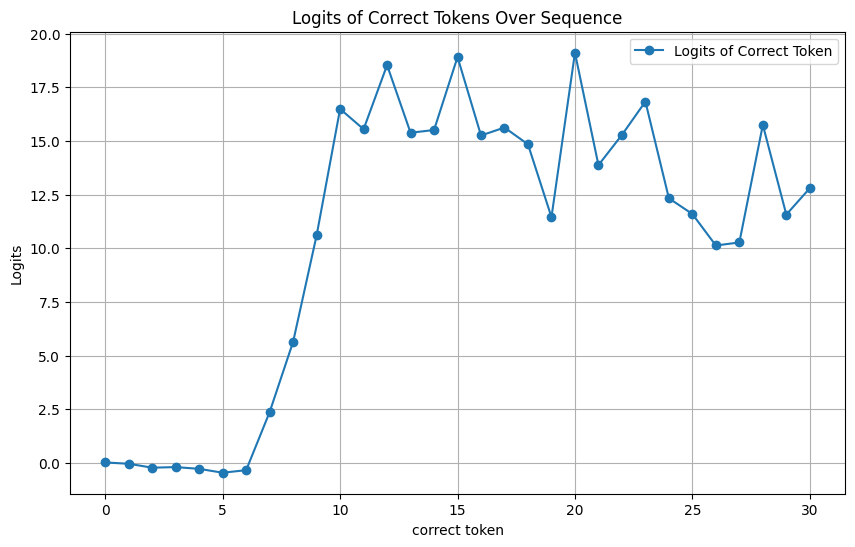

In [106]:
import matplotlib.pyplot as plt
# Shift true tokens by one position to align with predictions
true_tokens = tokens[:, 1:]

# Extract the logits of the correct token at each position
correct_logits = logits[:, :-1].gather(2, true_tokens.unsqueeze(-1)).squeeze(-1)

# Convert tensors to CPU for plotting
correct_logits = correct_logits.squeeze().cpu().detach().numpy()

# Create a line plot of logits for the correct token at each position
plt.figure(figsize=(10, 6))
plt.plot(correct_logits, label='Logits of Correct Token', marker='o')
plt.title('Logits of Correct Tokens Over Sequence')
plt.xlabel('correct token')
plt.ylabel('Logits')
plt.legend()
plt.grid(True)
plt.show()

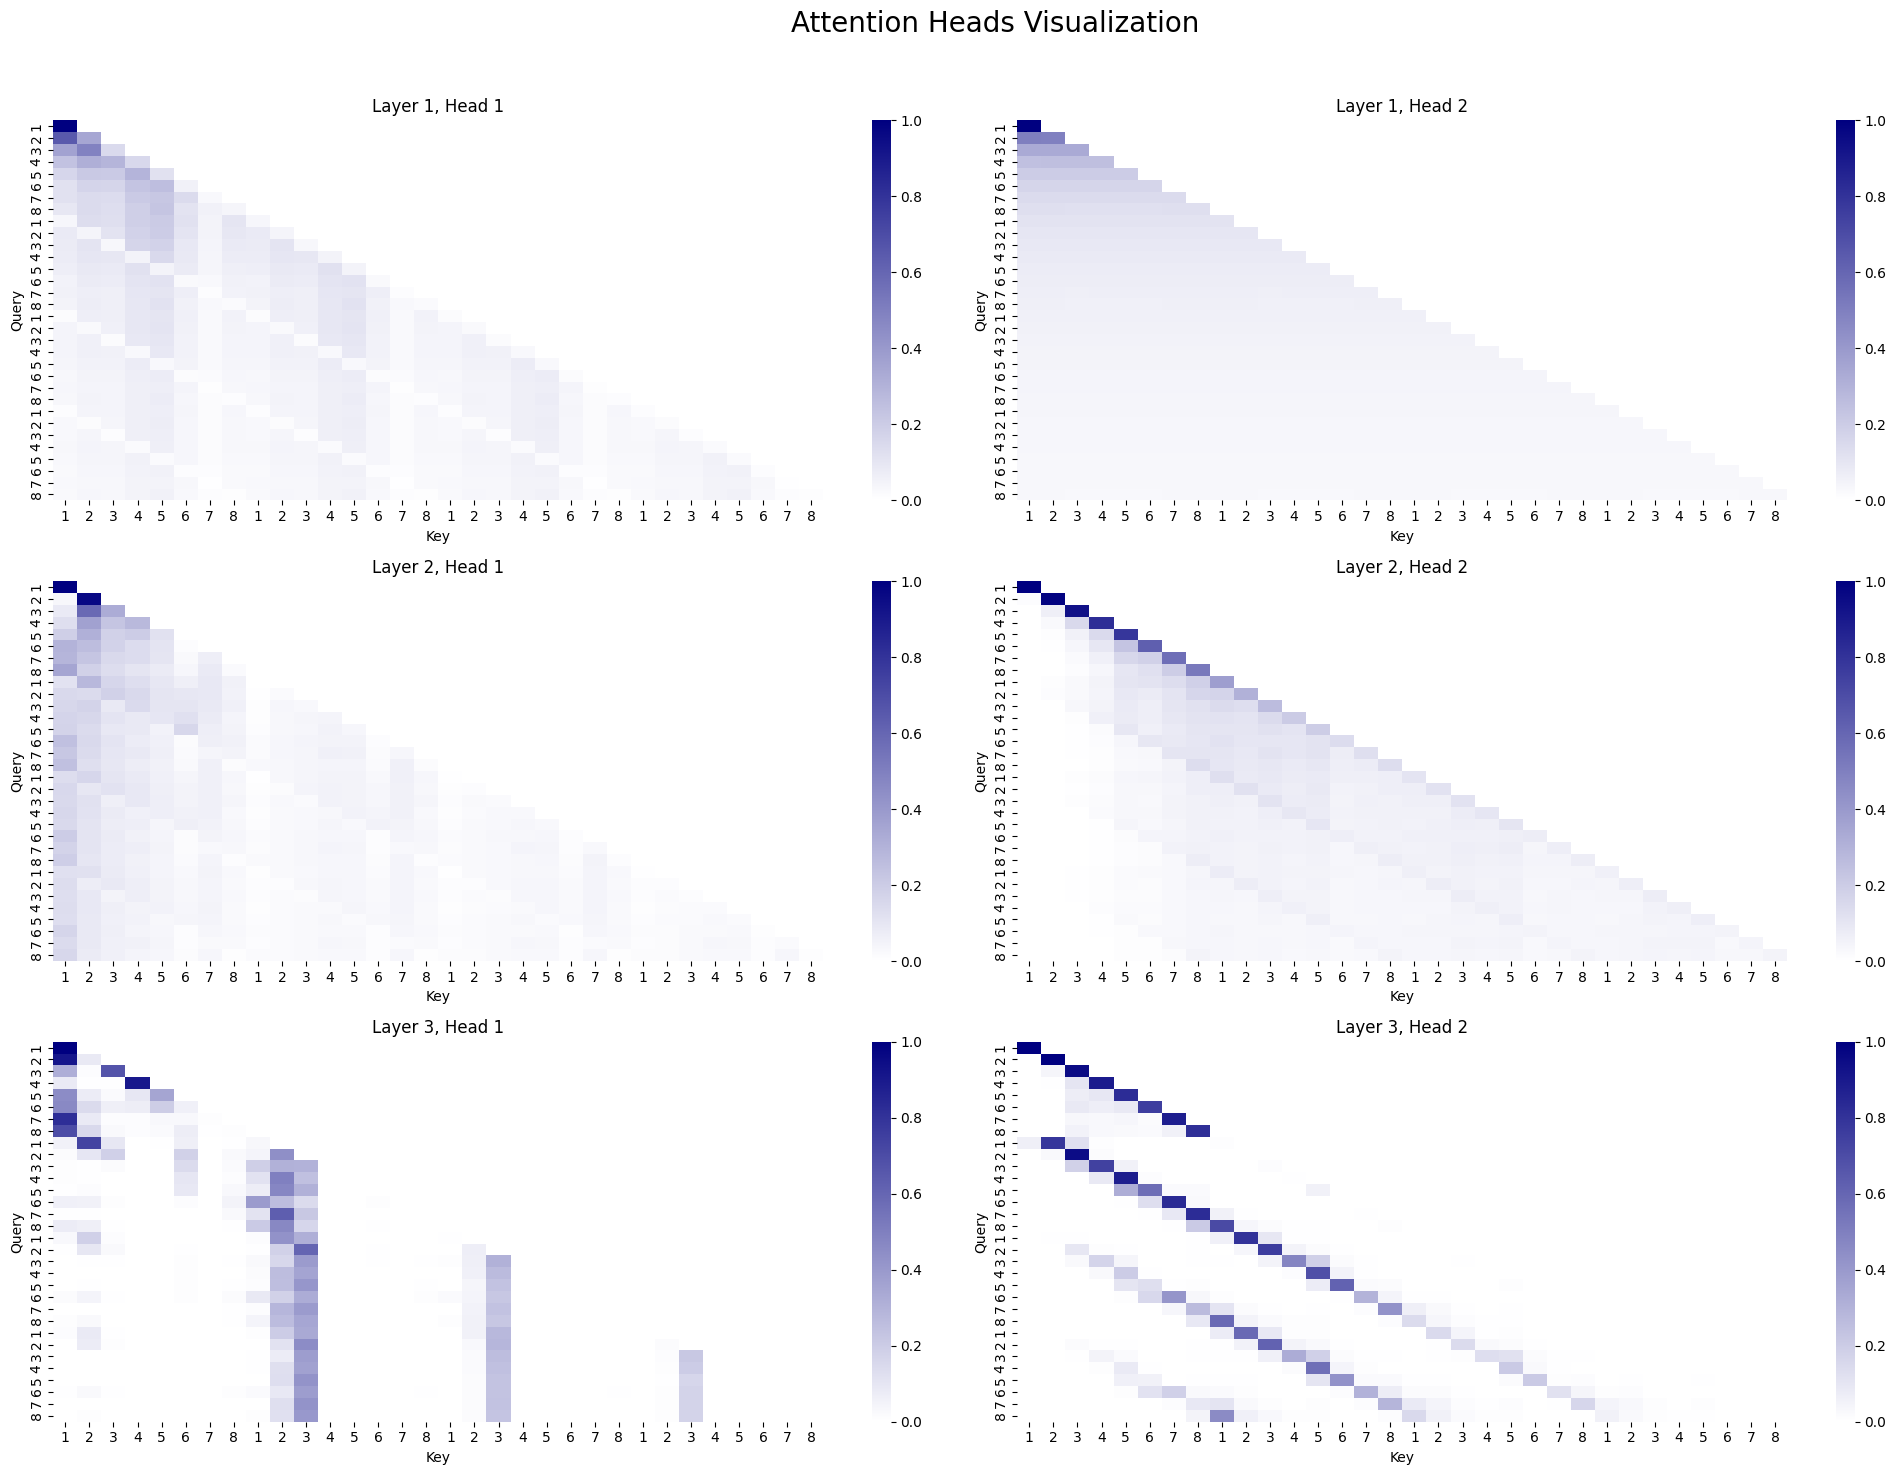

In [108]:


# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # Assume all_attn_weights is a list of attention weight tensors (one per layer)

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for all heads across all layers
    visualize_attention_all_layers(all_attn_weights, tokens_str)


In [109]:
# Your dataset and data loader
pattern2 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8,9,8,7,6,5,4,3,2]*2).unsqueeze(0).to(device)  # Move pattern to the device
customex = CustomDataset(pattern2)
custom_loader = DataLoader(customex, batch_size=1, shuffle=False)

for batch in custom_loader:
    tokens = batch['tokens'].to(device)  # Move tokens to the device
    logits, all_attn_weights = model(tokens)  # Get model output (logits)

    # Predicted tokens: take argmax over logits (ignoring the last position for prediction)
    predicted_tokens = logits[:, :-1].argmax(dim=-1)

    # True tokens (shifted by one to align with predicted tokens)
    true_tokens = tokens[:, 1:]  # Shift true tokens to align with prediction

    # Calculate accuracy: number of correct predictions divided by total predictions
    accuracy = (predicted_tokens == true_tokens).float().mean().item()

    # Print true tokens, predicted tokens, and accuracy
    print("True tokens:     ", true_tokens.squeeze().tolist())
    print("Predicted tokens:", predicted_tokens.squeeze().tolist())
    print(f"Accuracy:        {accuracy * 100:.2f}%")

True tokens:      [2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2]
Predicted tokens: [7, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2]
Accuracy:        51.61%


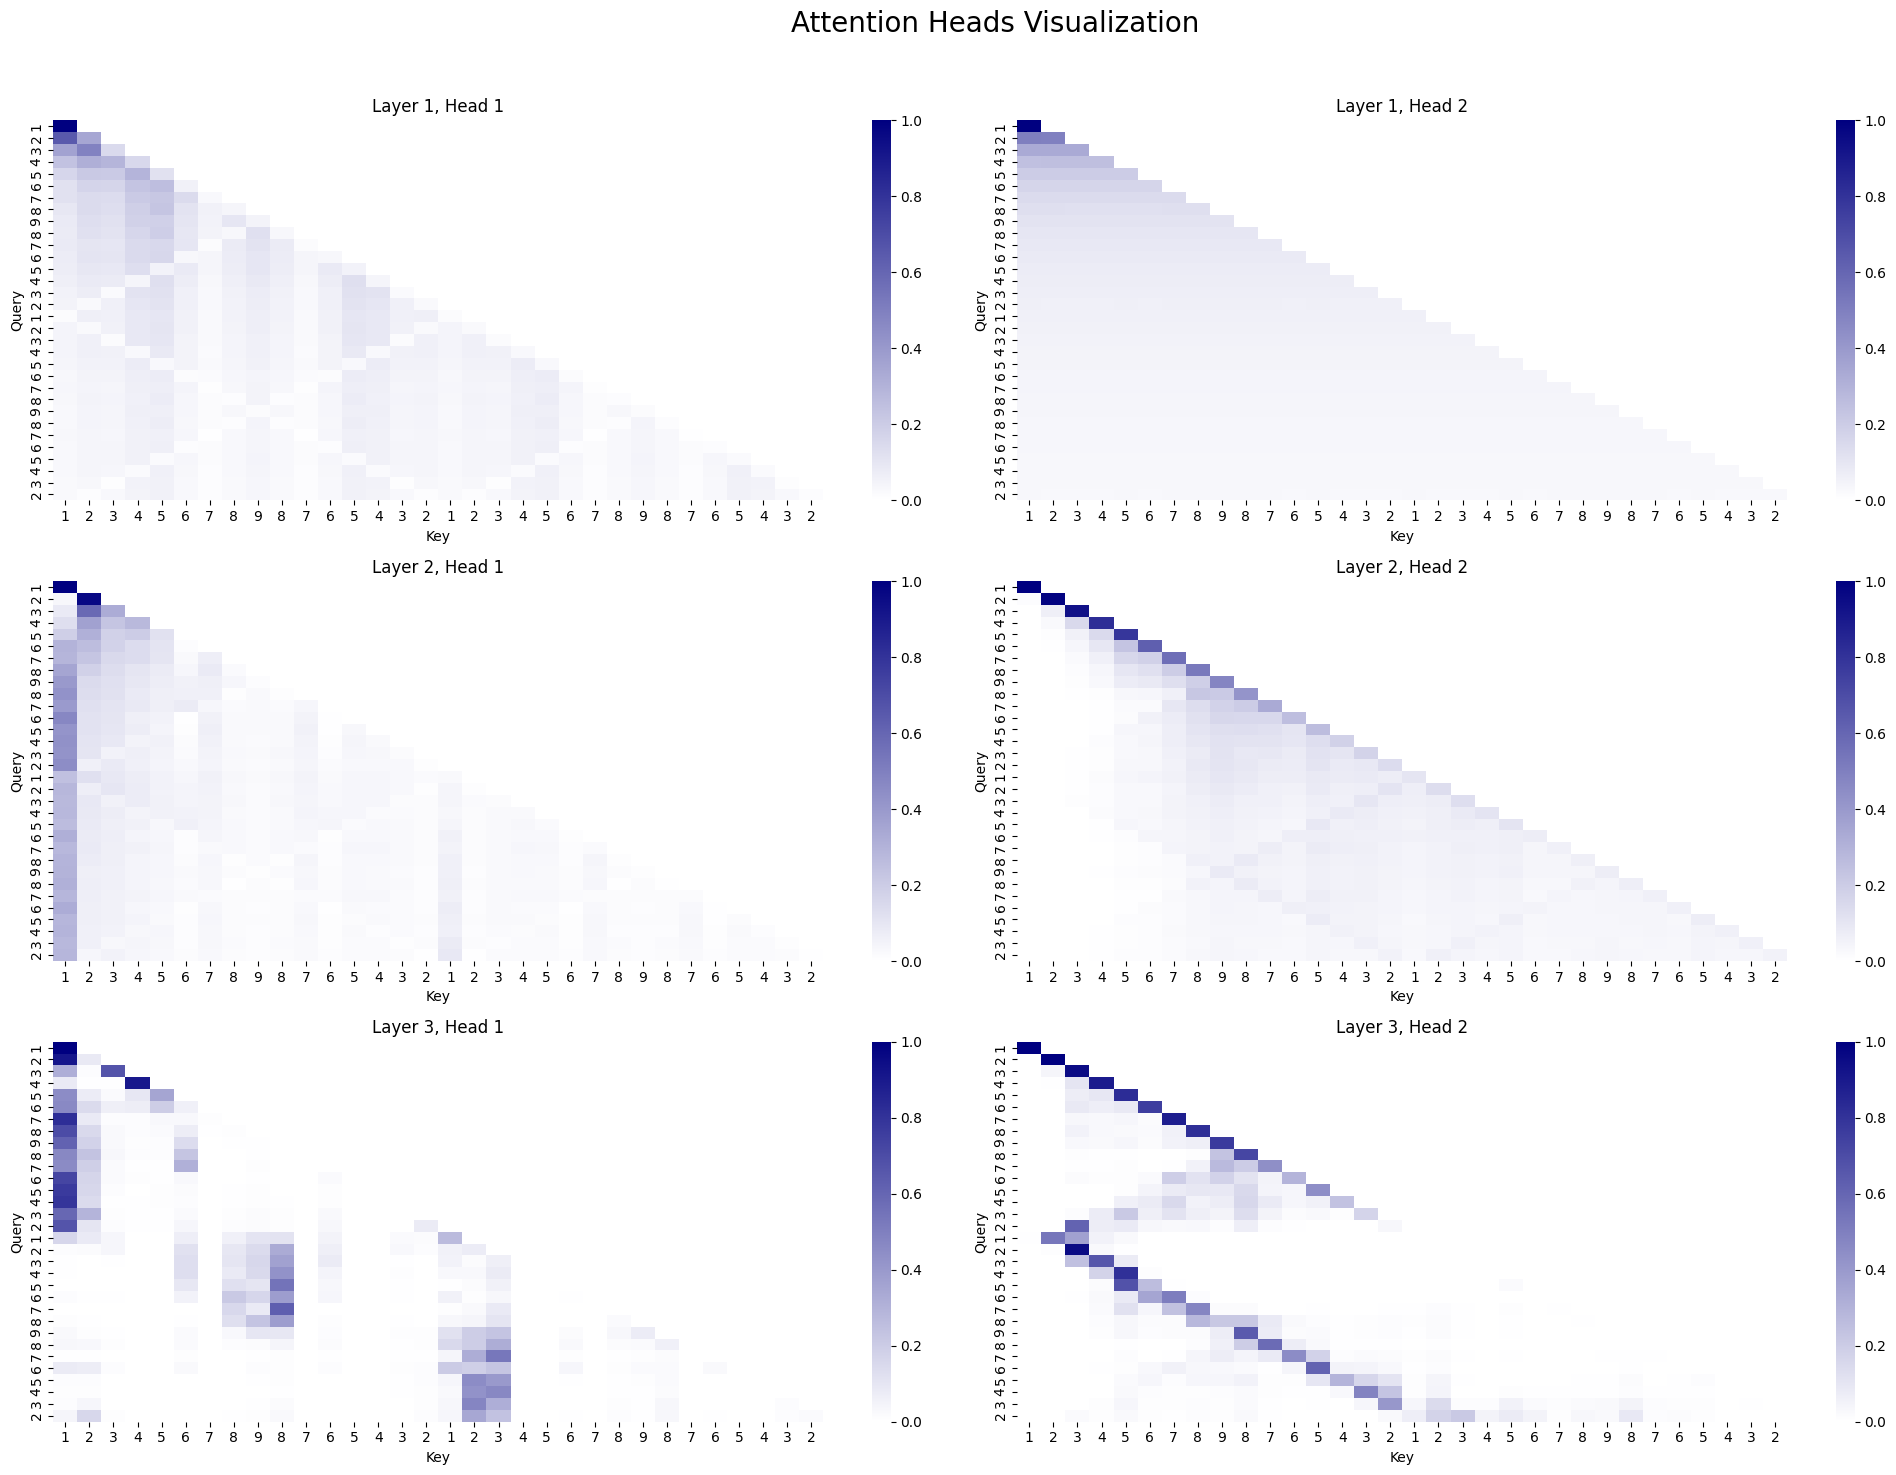

In [110]:


# Assuming the model and data loader are defined
for batch in custom_loader:
    tokens = batch['tokens']
    logits, all_attn_weights = model(tokens)  # Assume all_attn_weights is a list of attention weight tensors (one per layer)

    # Convert token ids to actual tokens if necessary
    tokens_str = [str(token.item()) for token in tokens[0]]  # Example token conversion to string

    # Visualize attention for all heads across all layers
    visualize_attention_all_layers(all_attn_weights, tokens_str)


### Observation: the 3-layers model was able to learn the task. Surprisingly, the model performed better on the ABAB task.